In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pypsa
import yaml

from pypsa.descriptors import get_switchable_as_dense as as_dense

plt.style.use('fivethirtyeight')

In [10]:
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

short_names = config['carriers_short_names']

network = pypsa.Network('../networks/pilot_elec-vre-hydro_simpl_TY2030_2010.nc')

INFO:pypsa.io:Imported network pilot_elec-vre-hydro_simpl_TY2030_2010.nc has buses, carriers, generators, links, loads, stores


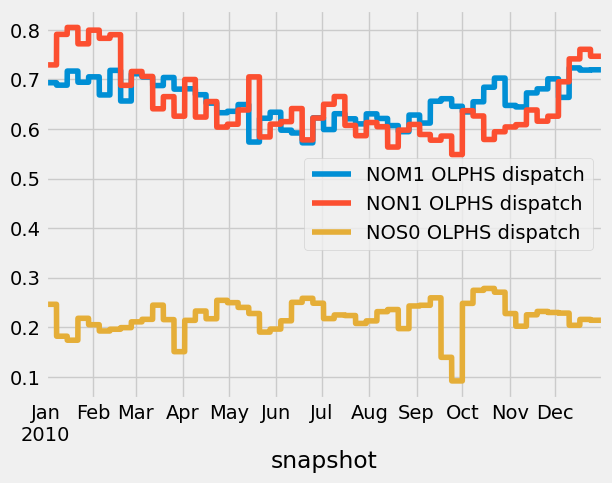

In [3]:
#network_orig.links_t.p_max_pu['NON1 onwind'].plot(label='orig 1', alpha=0.5)
#network_orig.links_t.p_max_pu['NOM1 onwind'].plot(label='orig 2', alpha=0.5)
#network_orig.links_t.p_max_pu['NOS0 onwind'].plot(label='orig 3', alpha=0.5)
network_simpl.links_t.p_max_pu[network_simpl.links.index[network_simpl.links.bus0=='NO OLPHS']].plot(label='simpl')
plt.legend()

In [4]:
def add_shedding(network):
    loads_i = network.loads.index
    buses = network.loads.bus.values
    names = [c+' shedding' for c in loads_i]
    p_nom = network.loads_t.p_set.max().values
    p_max_pu = (network.loads_t.p_set / p_nom).values
    
    network.add('Carrier', 'Load')
    network.madd('Generator', names, p_nom=p_nom, p_max_pu=p_max_pu, marginal_cost=1e3, bus=buses, carrier='Load')

In [5]:
def remove_stores(network, stores=None):
    if stores is None:
        stores = network.stores.index

    for store in stores:
        bus = network.stores.bus[store]
        gens = network.generators.index[network.generators.bus==bus]
        disp_links = network.links.index[network.links.bus0==bus]
        store_links = network.links.index[network.links.bus1==bus]

        network.mremove('Link', disp_links)
        network.mremove('Link', store_links)
        network.mremove('Generator', gens)
        network.remove('Store', store)
        network.remove('Bus', bus)

In [6]:
def aggregate_store_links(network, stores=None):

    if stores is None:
        stores = network.stores.index

    for store in stores:
        bus = network.stores.bus[store]
        gens = network.generators.index[network.generators.bus==bus]
        disp_links = network.links.index[network.links.bus0==bus]
        store_links = network.links.index[network.links.bus1==bus]
        basename = ' '.join([store.split(' ')[0][:2], store.split(' ')[1]])
        
        store_p_nom = network.links.p_nom[store_links].sum()
        disp_p_nom = network.links.p_nom[disp_links].sum()

        p_max_pu = as_dense(network, 'Link', 'p_max_pu', network.snapshots)
        p_min_pu = as_dense(network, 'Link', 'p_min_pu', network.snapshots)
        
        disp_p_max = p_max_pu[disp_links].mul(network.links.p_nom[disp_links]).mean(axis=1)
        disp_p_min = p_min_pu[disp_links].mul(network.links.p_nom[disp_links]).mean(axis=1)
        network.add('Link', f'{basename} dispatch', bus0=bus, bus1=bus[:2], p_nom=disp_p_nom, p_max_pu=disp_p_max / disp_p_nom, p_min_pu=disp_p_min / disp_p_nom)
        
        if store_p_nom > 0.:
            store_p_min = p_min_pu[store_links].mul(network.links.p_nom[store_links]).mean(axis=1)
            store_p_max = p_max_pu[store_links].mul(network.links.p_nom[store_links]).mean(axis=1)
            network.add('Link', f'{basename} store', bus0=bus[:2], bus1=bus, p_nom=store_p_nom, p_max_pu=store_p_max / store_p_nom, p_min_pu=store_p_min / store_p_nom)

        network.mremove('Link', disp_links)
        network.mremove('Link', store_links)

In [59]:
#def prepare_network(network, snapshots):

week = 32

network = pypsa.Network('../networks/pilot_elec-vre-hydro_simpl_TY2030_2010.nc')
weekstarts = pd.date_range(start=network.snapshots[0], end=network.snapshots[-1], freq='7D')
snapshots = pd.date_range(start=weekstarts[week], periods=168, freq='1H')

network.remove('Link', 'LUB1-BE00 HVAC')
network.set_snapshots(snapshots)
add_shedding(network)

### avoid infeasibilities caused by e_initial and e_min/max_pu
stores = network.stores
e_min_pu = as_dense(network, 'Store', 'e_min_pu', snapshots)
e_max_pu = as_dense(network, 'Store', 'e_max_pu', snapshots)

new_e_initial = pd.Series()
for store in stores.index:
    if not stores.e_initial_per_period[store]: continue
    e_min = e_min_pu.at[snapshots[0], store] * stores.e_nom[store] 
    e_max = e_max_pu.at[snapshots[0], store] * stores.e_nom[store]

    new_e_initial[store] = e_min + (e_max - e_min) / 2

network.stores.loc[new_e_initial.index, 'e_initial'] = new_e_initial

### p_min_pu of dispatch links may cause infeasibilities when inflow is insufficient to serve the minimum dispatch requirement and stores eneergy is bounded by e_min_pu
disp_links = network.links.index[network.links.carrier.isin(['hydro dispatch', 'OLPHS dispatch', 'CLPHS dispatch'])]
disp_links = disp_links[disp_links.isin(network.links_t.p_min_pu.columns)]
network.links_t.p_min_pu[disp_links] = 0. ### solves!
#network.links_t.p_max_pu[disp_links] = 1.

store_links = network.links.index[network.links.carrier.isin(['hydro store', 'OLPHS store', 'CLPHS store'])]
store_links = store_links[store_links.isin(network.links_t.p_max_pu.columns)]
#network.links_t.p_min_pu[store_links] = 0.
#network.links_t.p_max_pu[store_links] = 1.

#original_e_min_pu = network.stores_t.e_min_pu.copy()
#sol = pd.Series()
#for store in original_e_min_pu.columns: 
#    network.stores_t.e_min_pu.loc[:,:] = 0.
#    network.stores_t.e_min_pu.loc[:,store] = original_e_min_pu[store]
#    sol[store] = network.optimize(network.snapshots, solver_name='cbc', solver_options={'logPath': 'solver.log'})

#network.stores_t.e_min_pu.loc[:,['SK OLPHS OLPHS', 'SK hydro hydro']] *= 0.5
network.optimize(network.snapshots, solver_name='cbc', solver_options={'logPath': 'solver.log'})

INFO:pypsa.io:Imported network pilot_elec-vre-hydro_simpl_TY2030_2010.nc has buses, carriers, generators, links, loads, stores
INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - logPath: solver.log
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 24.09it/s]
INFO:linopy.io: Writing time: 1.01s


No match for logPath - ? for list of commands
No match for solver.log - ? for list of commands
Total time (CPU seconds):       3.58   (Wallclock seconds):       3.76



INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 141456 primals, 289464 duals
Objective: 9.84e+08
Solver model: not available
Solver message: Optimal - objective value 983683558.18783128


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [61]:
network.objective / network.loads_t.p_set.iloc[:48,:].sum().sum()

41.77439730172257

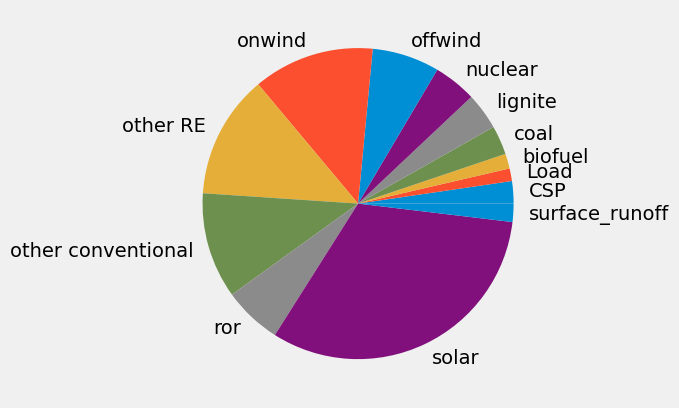

In [57]:
wedges = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum().sum()
plt.pie(wedges, labels=wedges.index)
plt.show()

In [58]:
wedges.sort_values() / network.loads_t.p_set.sum().sum() * 100

carrier
Load                   1.012384
biofuel                1.196472
surface_runoff         1.463686
CSP                    1.793090
coal                   2.325480
lignite                2.964906
nuclear                3.452066
ror                    4.693172
offwind                5.407746
other conventional     8.504706
onwind                 9.730114
other RE               9.925072
solar                 24.786165
dtype: float64